In [1]:
import mat73
import torch
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
os.sys.path.append("../")

from unroll.model.vanilla import Model
from gen_initial import gen_initial_multiscale, shift_h

use_cuda = True if torch.cuda.is_available() else False
# use_cuda = 0

In [2]:
## Load the histogram data with PPP=4, SBR=1
f = 'Art_4.0_1.0.mat'    
fdict = mat73.loadmat(f)
tof = torch.FloatTensor(fdict["Y"])

H, W, T = tof.shape
to_meter = T * 0.003 # depth scale factor from [0,1] -> the unit of meter

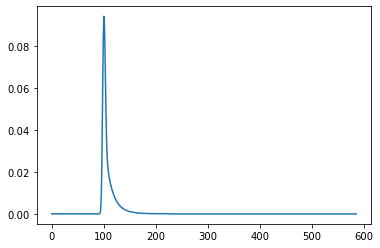

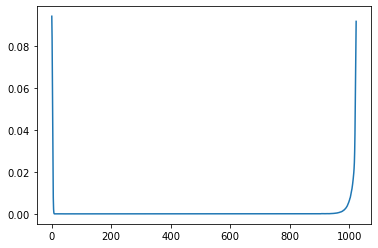

In [3]:
## Load and visualize the impulse response function
irf_ = scipy.io.loadmat("irf/irf_middlebury1024.mat")["irf"][0,:]
plt.plot(irf_); plt.show()
h1 = torch.FloatTensor(shift_h(irf_, T))

## Visualize the shifted IRF
plt.plot(h1); plt.show()

In [4]:
## Generate initial multiscale depths
L = 12
depths = gen_initial_multiscale(tof, h1, L, use_cuda=use_cuda)

Note that this code is optimized for CUDA. CPU-friendly version is implemented in Julia.
4 scales completed. We now generate 8 additional scales by separable 3d convolution.


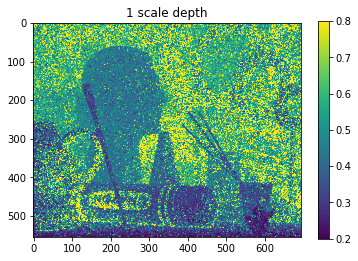

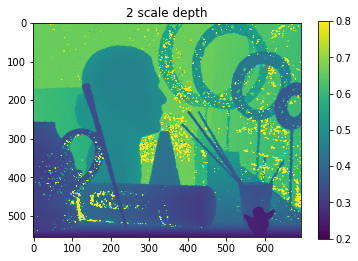

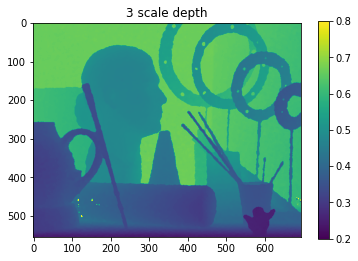

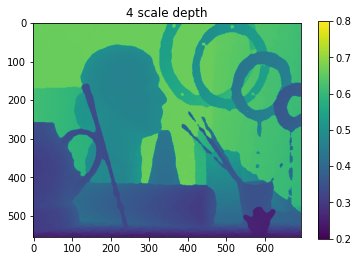

In [9]:
## Visualize the input initial multiscale depths
for i in range(4):
    plt.imshow(depths[i,:,:]*to_meter, vmin=0.2, vmax=0.8); plt.colorbar()
    plt.title(f"{i+1} scale depth"); plt.show() 

In [10]:
## Run the neural network
with torch.no_grad():
    model = Model(L)
    if use_cuda:
        model.cuda()
        model.load_state_dict(torch.load("model_baseline.pth"))
    else:
        model.load_state_dict(torch.load("model_baseline.pth", map_location=torch.device('cpu')))
    
    # to compute the uncertainty, turn on the debug option
    out = model(depths.unsqueeze(0), debug=True)

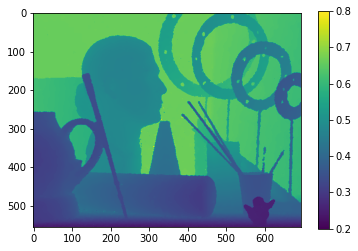

In [11]:
## Visualization of the results
depth_final = out[0][-1].cpu().numpy()

# # save the images for debugging
# depths = depths.cpu().numpy()

# if os.path.isdir("../fig/") == False:
#     os.makedirs("../fig/")

plt.imshow(depth_final[0,0,:,:]*to_meter); plt.clim(0.2, 0.8); plt.colorbar()

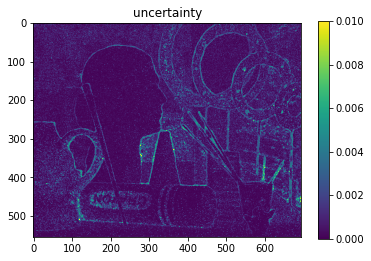

In [12]:
from compute_uncertainty import compute_uncertainty

eps = compute_uncertainty(out, to_meter=to_meter)
plt.imshow(eps, vmin=0, vmax=0.01)
plt.title("uncertainty")
plt.colorbar()
plt.show()